In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import pandas as pd
import random
import time
import numpy as np
import re
import string

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

root_path = "/content/drive/MyDrive/Colab Notebooks/COMP9444/"

Trans Dataset & add sentiments

In [4]:
# Label mapping (number to name)
label2sentiment = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

def convert_parquet_to_csv(input_path, output_path):
    df = pd.read_parquet(input_path)
    # number to string
    df["sentiment"] = df["label"].map(label2sentiment)
    # only save the required fields
    df = df[["text", "label", "sentiment"]]
    # export csv
    df.to_csv(output_path, index=False)
    print(f"save to: {output_path}, simple size: {len(df)}")

convert_parquet_to_csv(root_path+"Dataset/train-00000-of-00001.parquet", root_path+"Dataset/proj_train.csv")
convert_parquet_to_csv(root_path+"Dataset/validation-00000-of-00001.parquet", root_path+"Dataset/proj_val.csv")
convert_parquet_to_csv(root_path+"Dataset/test-00000-of-00001.parquet", root_path+"Dataset/proj_test.csv")

save to: /content/drive/MyDrive/Colab Notebooks/COMP9444/Dataset/proj_train.csv, simple size: 16000
save to: /content/drive/MyDrive/Colab Notebooks/COMP9444/Dataset/proj_val.csv, simple size: 2000
save to: /content/drive/MyDrive/Colab Notebooks/COMP9444/Dataset/proj_test.csv, simple size: 2000


In [5]:
train_data = pd.read_csv(root_path+"Dataset/proj_train.csv")
val_data = pd.read_csv(root_path+"Dataset/proj_val.csv")
test_data = pd.read_csv(root_path+"Dataset/proj_test.csv")
print(train_data.head())
print("col name:", train_data.columns)
print("category:", set(train_data["sentiment"]))

                                                text  label sentiment
0                            i didnt feel humiliated      0   sadness
1  i can go from feeling so hopeless to so damned...      0   sadness
2   im grabbing a minute to post i feel greedy wrong      3     anger
3  i am ever feeling nostalgic about the fireplac...      2      love
4                               i am feeling grouchy      3     anger
col name: Index(['text', 'label', 'sentiment'], dtype='object')
category: {'fear', 'surprise', 'sadness', 'joy', 'anger', 'love'}


Text Preprocessing & Finding the Length

In [6]:
# Contractions spread dict
contractions_dict = {"aint": "am not",
                     "ain t": "am not",
                     "arent": "are not",
                     "aren t": "are not",
                     "cant": "cannot",
                     "can t": "cannot",
                     "couldve": "could have",
                     "couldnt": "could not",
                     "couldn t": "could not",
                     "didnt": "did not",
                     "didn t": "did not",
                     "doesnt": "does not",
                     "doesn t": "does not",
                     "dont": "do not",
                     "don t": "do not",
                     "hadnt": "had not",
                     "hadn t": "had not",
                     "hasnt": "has not",
                     "hasn t": "has not",
                     "havent": "have not",
                     "haven t": "have not",
                     "hed": "he would",
                     "he d": "he would",
                     "he ll": "he will",
                     "hes": "he is",
                     "he s": "he is",
                     "howd": "how did",
                     "how d": "how did",
                     "howll": "how will",
                     "how ll": "how will",
                     "hows": "how is",
                     "how s": "how is",
                     "i d": "i would",
                     "i dve": "i would have",
                     "i ll": "i will",
                     "i llve": "i will have",
                     "im": "i am",
                     "i m": "i am",
                     "ive": "i have",
                     "isnt": "is not",
                     "isn t": "is not",
                     "itd": "it would",
                     "it d": "it would",
                     "itdve": "it would have",
                     "it dve": "it would have",
                     "itll": "it will",
                     "it ll": "it will",
                     "itllve": "it will have",
                     "it llve": "it will have",
                     "its": "it is",
                     "it s": "it is",
                     "lets": "let us",
                     "let s": "let us",
                     "maam": "madam",
                     "ma am": "madam",
                     "maynt": "may not",
                     "mayn t": "may not",
                     "mightve": "might have",
                     "mightnt": "might not",
                     "mightn t": "might not",
                     "mightntve": "might not have",
                     "mustve": "must have",
                     "mustnt": "must not",
                     "mustn t": "must not",
                     "mustntve": "must not have",
                     "neednt": "need not",
                     "needn t": "need not",
                     "needntve": "need not have",
                     "oclock": "of the clock",
                     "o clock": "of the clock",
                     "oughtnt": "ought not",
                     "oughtn t": "ought not",
                     "oughtntve": "ought not have",
                     "shant": "shall not",
                     "shan t": "shall not",
                     "shed": "she would",
                     "she d": "she would",
                     "shedve": "she would have",
                     "she ll": "she will",
                     "shes": "she is",
                     "she s": "she is",
                     "shouldve": "should have",
                     "shouldnt": "should not",
                     "shouldn t": "should not",
                     "shouldntve": "should not have",
                     "sove": "so have",
                     "so s": "so as",
                     "this s": "this is",
                     "thatd": "that would",
                     "that d": "that would",
                     "thatdve": "that would have",
                     "thats": "that is",
                     "that s": "that is",
                     "thered": "there would",
                     "there d": "there would",
                     "theredve": "there would have",
                     "theres": "there is",
                     "there s": "there is",
                     "here s": "here is",
                     "theyd": "they would",
                     "they d": "they would",
                     "theydve": "they would have",
                     "theyll": "they will",
                     "they ll": "they will",
                     "theyllve": "they will have",
                     "theyre": "they are",
                     "they re": "they are",
                     "theyve": "they have",
                     "tove": "to have",
                     "wasnt": "was not",
                     "wasn t": "was not",
                     "wed": "we would",
                     "we d": "we would",
                     "wedve": "we would have",
                     "we ll": "we will",
                     "we re": "we are",
                     "werent": "were not",
                     "weren t": "were not",
                     "what ll": "what will",
                     "whatre": "what are",
                     "what re": "what are",
                     "whats": "what is",
                     "what s": "what is",
                     "whatve": "what have",
                     "whens": "when is",
                     "when s": "when is",
                     "whenve": "when have",
                     "whered": "where did",
                     "where d": "where did",
                     "wheres": "where is",
                     "where s": "where is",
                     "whereve": "where have",
                     "wholl": "who will",
                     "who ll": "who will",
                     "whollve": "who will have",
                     "whos": "who is",
                     "who s": "who is",
                     "whove": "who have",
                     "whys": "why is",
                     "why s": "why is",
                     "whyve": "why have",
                     "willve": "will have",
                     "wont": "will not",
                     "won t": "will not",
                     "wontve": "will not have",
                     "wouldve": "would have",
                     "wouldnt": "would not",
                     "wouldn t": "would not",
                     "wouldntve": "would not have",
                     "y all": "you all",
                     "y all d": "you all would",
                     "y all re": "you all are",
                     "youd": "you would",
                     "you d": "you would",
                     "youdve": "you would have",
                     "youll": "you will",
                     "you ll": "you will",
                     "youre": "you are",
                     "you re": "you are",
                     "youve": "you have",
                     "u": "you",
                     "ve": "have"}
pattern_str = r'(?<!\w)(' + '|'.join(map(re.escape, contractions_dict.keys())) + r')(?!\w)'
contractions_pattern = re.compile(pattern_str)

# Replacing contractions with expansions
def replace_contractions(text, contraction_dict, contractions_pattern):
    def replace(match):
        return contraction_dict[match.group(0)]
    return contractions_pattern.sub(replace, text)

# Remove punctuation and numbers
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

# Remove all non-alphanumeric spaces and number characters
def clean_text(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

def text_preprocessing(text, contraction_dict, contractions_pattern):
    text = replace_contractions(text, contraction_dict, contractions_pattern)
    text = remove_punct(text)
    text = clean_text(text)
    text = text.lower()
    return text

In [7]:
train_data["text"] = train_data["text"].apply(lambda x: text_preprocessing(x, contractions_dict, contractions_pattern))
train_data['length'] = train_data['text'].apply(lambda x: len(str(x).split()))
print(train_data)
train_max_length = train_data['length'].max()
print(f"The maximum length is: {train_max_length}")

                                                    text  label sentiment  \
0                              i did not feel humiliated      0   sadness   
1      i can go from feeling so hopeless to so damned...      0   sadness   
2      i am grabbing a minute to post i feel greedy w...      3     anger   
3      i am ever feeling nostalgic about the fireplac...      2      love   
4                                   i am feeling grouchy      3     anger   
...                                                  ...    ...       ...   
15995  i just had a very brief time in the beanbag an...      0   sadness   
15996  i am now turning and i feel pathetic that i am...      0   sadness   
15997                     i feel strong and good overall      1       joy   
15998  i feel like this was such a rude comment and i...      3     anger   
15999  i know a lot but i feel so stupid because i ca...      0   sadness   

       length  
0           5  
1          21  
2          11  
3          

In [8]:
val_data["text"] = val_data["text"].apply(lambda x: text_preprocessing(x, contractions_dict, contractions_pattern))
val_data['length'] = val_data['text'].apply(lambda x: len(str(x).split()))
print(val_data)
val_max_length = val_data['length'].max()
print(f"The maximum length is: {val_max_length}")

                                                   text  label sentiment  \
0     i am feeling quite sad and sorry for myself bu...      0   sadness   
1     i feel like i am still looking at a blank canv...      0   sadness   
2                        i feel like a faithful servant      2      love   
3                     i am just feeling cranky and blue      3     anger   
4     i can have for a treat or if i am feeling festive      1       joy   
...                                                 ...    ...       ...   
1995  i am having ssa examination tomorrow in the mo...      0   sadness   
1996  i constantly worry about their fight against n...      1       joy   
1997  i feel it is important to share this info for ...      1       joy   
1998  i truly feel that if you are passionate enough...      1       joy   
1999  i feel like i just wanna buy any cute make up ...      1       joy   

      length  
0         16  
1         15  
2          6  
3          7  
4         12

In [9]:
test_data["text"] = test_data["text"].apply(lambda x: text_preprocessing(x, contractions_dict, contractions_pattern))
test_data['length'] = test_data['text'].apply(lambda x: len(str(x).split()))
print(test_data)
test_max_length = test_data['length'].max()
print(f"The maximum length is: {test_max_length}")

                                                   text  label sentiment  \
0     i am feeling rather rotten so i am not very am...      0   sadness   
1           i am updating my blog because i feel shitty      0   sadness   
2     i never make her separate from me because i do...      0   sadness   
3     i left with my bouquet of red and yellow tulip...      1       joy   
4       i was feeling a little vain when i did this one      0   sadness   
...                                                 ...    ...       ...   
1995  i just keep feeling like someone is being unki...      3     anger   
1996  i am feeling a little cranky negative after th...      3     anger   
1997  i feel that i am useful to my people and that ...      1       joy   
1998  i am feeling more comfortable with derby i fee...      1       joy   
1999  i feel all weird when i have to meet w people ...      4      fear   

      length  
0         13  
1          9  
2         22  
3         21  
4         11

Show count and percentage of categories

In [10]:
train_data['sentiment'].value_counts()
counts = train_data['sentiment'].value_counts()
percents = train_data['sentiment'].value_counts(normalize=True) * 100
train_df_stats = pd.DataFrame({'count': counts, 'percent': percents})
print(train_df_stats)

           count   percent
sentiment                 
joy         5362  33.51250
sadness     4666  29.16250
anger       2159  13.49375
fear        1937  12.10625
love        1304   8.15000
surprise     572   3.57500


In [11]:
val_data['sentiment'].value_counts()
counts = val_data['sentiment'].value_counts()
percents = val_data['sentiment'].value_counts(normalize=True) * 100
val_df_stats = pd.DataFrame({'count': counts, 'percent': percents})
print(val_df_stats)

           count  percent
sentiment                
joy          704    35.20
sadness      550    27.50
anger        275    13.75
fear         212    10.60
love         178     8.90
surprise      81     4.05


In [12]:
test_data['sentiment'].value_counts()
counts = test_data['sentiment'].value_counts()
percents = test_data['sentiment'].value_counts(normalize=True) * 100
test_df_stats = pd.DataFrame({'count': counts, 'percent': percents})
print(test_df_stats)

           count  percent
sentiment                
joy          695    34.75
sadness      581    29.05
anger        275    13.75
fear         224    11.20
love         159     7.95
surprise      66     3.30


Parameters

In [13]:
# how big is each word vector
embed_size = 300
# how many unique words to use
max_features = 100000
# max number of words in text to use
# 72 is the maximum length in 3 sets
maxlen = 72

Padding Dataset

In [14]:
# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_data['text'])
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
val_sequences = tokenizer.texts_to_sequences(val_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

word_counts = len(tokenizer.word_index)
print(f"tokenizer have learned {word_counts} unique words.")

num_used_words = min(max_features, len(tokenizer.word_index))
print(f"model really used {num_used_words} words.")

percent = num_used_words / len(tokenizer.word_index) * 100
print(f"this took {percent:.2f}%")

# Pad the sequences
train_sequences = pad_sequences(train_sequences, maxlen=maxlen, truncating='post', padding='post')
val_sequences = pad_sequences(val_sequences, maxlen=maxlen, truncating='post', padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=maxlen, truncating='post', padding='post')

tokenizer have learned 15155 unique words.
model really used 15155 words.
this took 100.00%


Get tabbed columns (numpy arrays)

In [15]:
train_label = train_data['label'].values
val_label = val_data['label'].values
test_label = test_data['label'].values

print(train_label.shape)
print(val_label.shape)
print(test_label.shape)

(16000,)
(2000,)
(2000,)


Word Emebedding (Glove.6B.300d)

In [16]:
def load_glove(word_index):
    EMBEDDING_FILE = root_path+'glove.6B/glove.6B.300d.txt'

    # Defining functions split a line of GloVe text into words and vectors
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]

    # Read the entire GloVe word vector file and do a split on each line
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    # A list of all word vectors
    vals = list(embeddings_index.values())

    print("Number of embeddings:", len(vals))
    print("Type of first element:", type(vals[0]))
    print("Shape of first embedding:", vals[0].shape)
    print("First word:", list(embeddings_index.keys())[0])
    print("First embedding:", vals[0][:5])
    # Generate a two-dimensional matrix of word vectors, each row is a word vector
    all_embs = np.stack(vals)

    emb_mean = np.mean(vals)
    emb_std = np.std(vals)
    print('Embedding mean:', emb_mean)
    print('Embedding std:', emb_std)

    # Get vector dimension
    embed_size = all_embs.shape[1]

    # Final number of words to be used
    nb_words = min(max_features, len(word_index)+1)
    print(f"nb_words: {nb_words}")

    # If no word vector for GloVe is found, use this matrix.
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))


    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove(tokenizer.word_index)
print('Shape of word embedding:',np.shape(embedding_matrix))

Number of embeddings: 400000
Type of first element: <class 'numpy.ndarray'>
Shape of first embedding: (300,)
First word: the
First embedding: [ 0.04656    0.21318   -0.0074364 -0.45854   -0.035639 ]
Embedding mean: -0.0039050116
Embedding std: 0.38177028
nb_words: 15156
Shape of word embedding: (15156, 300)


Setting Training Hyperparameters

In [32]:
n_epochs = 15
filter_sizes = [2,3,5]
num_filters = 32
n_classes = train_data['label'].nunique()
# print(n_classes)
batch_size = 512

Convolutional Neural Network (CNN)

In [17]:
class CNN(nn.Module):
    def __init__(self,num_filters,filter_sizes,n_classes):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc1(x)
        return logit

CNN Model Configure & Main Loop

In [33]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_cnn = CNN(num_filters,filter_sizes,n_classes).to(device)
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_cnn.parameters()), lr=0.001)

# Load data in CUDA or CPU Memory
x_train = torch.tensor(train_sequences, dtype=torch.long).to(device)
y_train = torch.tensor(train_label, dtype=torch.long).to(device)
x_val = torch.tensor(val_sequences, dtype=torch.long).to(device)
y_val = torch.tensor(val_label, dtype=torch.long).to(device)
x_test = torch.tensor(test_sequences, dtype=torch.long).to(device)
y_test = torch.tensor(test_label, dtype=torch.long).to(device)

# Create Torch datasets
indices = np.arange(len(x_train))
train_set = torch.utils.data.TensorDataset(x_train, y_train, torch.tensor(indices))
val_set = torch.utils.data.TensorDataset(x_val, y_val)
test_set = torch.utils.data.TensorDataset(x_test, y_test)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

cnn_train_loss_list = []
cnn_val_loss_list = []
cnn_train_acc_list, cnn_val_acc_list, cnn_prec_list, cnn_recall_list, cnn_f1_list = [],[],[],[],[]

'''
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
'''

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model_cnn.train()
    # Reset avg_train_loss epoch
    avg_train_loss = 0.
    train_preds = np.zeros((len(x_train), n_classes))
    train_true = np.zeros(len(x_train))
    for i, (x_batch, y_batch, idx_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        # Predict/Forward Pass
        y_pred = model_cnn(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        preds = F.softmax(y_pred, dim=1).detach().cpu().numpy()
        idxs = idx_batch.cpu().numpy()
        train_preds[idxs] = preds
        train_true[idxs] = y_batch.cpu().numpy()

        avg_train_loss += loss.item() / len(train_loader)
    y_pred_train = train_preds.argmax(axis=1)
    train_accuracy = round(accuracy_score(y_pred_train, train_true)*100,3)
    # Set model to validation configuration -Doesn't get trained here
    model_cnn.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_val), n_classes))
    with torch.no_grad():
      for i, (x_batch, y_batch) in enumerate(val_loader):
          y_pred = model_cnn(x_batch)
          start_idx = i * batch_size
          end_idx = start_idx + len(x_batch)
          loss = loss_fn(y_pred, y_batch)
          # keep/store predictions
          val_preds[start_idx:end_idx] = F.softmax(y_pred, dim=1).detach().cpu().numpy()
          avg_val_loss += loss.item() / len(val_loader)
    # Determining Accuracy, Precision, Recall, F1 Score
    y_pred_val = val_preds.argmax(axis=1)
    val_accuracy = round(accuracy_score(y_pred_val, y_val.cpu().numpy())*100,3)
    val_precision = round(precision_score(y_pred_val, y_val.cpu().numpy(), average='weighted')*100,3)
    val_recall = round(recall_score(y_pred_val, y_val.cpu().numpy(), average='weighted')*100,3)
    val_f1_score = round(f1_score(y_pred_val, y_val.cpu().numpy(), average='weighted')*100,3)


    # storing accuracy,precision,recall,f1 score data into list
    cnn_train_loss_list.append(avg_train_loss)
    cnn_val_loss_list.append(avg_val_loss)
    cnn_train_acc_list.append(train_accuracy)
    cnn_val_acc_list.append(val_accuracy)
    cnn_prec_list.append(val_precision)
    cnn_recall_list.append(val_recall)
    cnn_f1_list.append(val_f1_score)
    elapsed_time = time.time() - start_time
    print("Epoch {}/{}  Train loss={:.3f}   Val loss={:.3f}   Train Accuracy={:.3f}   Val Accuracy={:.3f}   Precision={:.3f}   Recall={:.3f}   F1 Score={:.3f}   time={:.2f} s".format(
                epoch + 1, n_epochs, avg_train_loss, avg_val_loss, train_accuracy, val_accuracy, val_precision, val_recall, val_f1_score, elapsed_time))

Epoch 1/15  Train loss=1.484   Val loss=1.265   Train Accuracy=44.750   Val Accuracy=56.450   Precision=88.156   Recall=56.450   F1 Score=68.366   time=34.97 s
Epoch 2/15  Train loss=1.064   Val loss=0.857   Train Accuracy=63.281   Val Accuracy=70.900   Precision=85.549   Recall=70.900   F1 Score=76.360   time=32.73 s
Epoch 3/15  Train loss=0.746   Val loss=0.622   Train Accuracy=74.562   Val Accuracy=79.400   Precision=84.358   Recall=79.400   F1 Score=81.188   time=34.76 s
Epoch 4/15  Train loss=0.566   Val loss=0.492   Train Accuracy=80.981   Val Accuracy=84.250   Precision=85.458   Recall=84.250   F1 Score=84.652   time=32.85 s
Epoch 5/15  Train loss=0.450   Val loss=0.409   Train Accuracy=85.069   Val Accuracy=86.000   Precision=87.364   Recall=86.000   F1 Score=86.396   time=34.46 s
Epoch 6/15  Train loss=0.385   Val loss=0.360   Train Accuracy=86.806   Val Accuracy=88.000   Precision=88.189   Recall=88.000   F1 Score=88.044   time=32.77 s
Epoch 7/15  Train loss=0.332   Val loss=

CNN Model Evaluation

In [34]:
cnn_mean_train_acc = np.mean(cnn_train_acc_list)
cnn_mean_val_acc = np.mean(cnn_val_acc_list)
cnn_mean_train_loss = np.mean(cnn_train_loss_list)
cnn_mean_val_loss = np.mean(cnn_val_loss_list)

print(f"Averag Train Accuracy on CNN: {cnn_mean_train_acc:.3f}")
print(f"Averag Val Accuracy on CNN: {cnn_mean_val_acc:.3f}")
print(f"Averag Train Loss on CNN: {cnn_mean_train_loss:.3f}")
print(f"Averag Val Loss on CNN: {cnn_mean_val_loss:.3f}")

Averag Train Accuracy on CNN: 84.535
Averag Val Accuracy on CNN: 84.890
Averag Train Loss on CNN: 0.449
Averag Val Loss on CNN: 0.433


CNN Model Visualisation

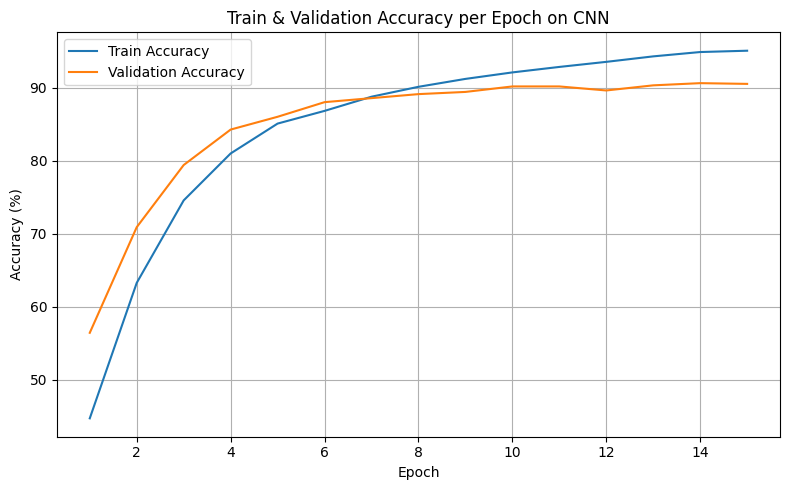

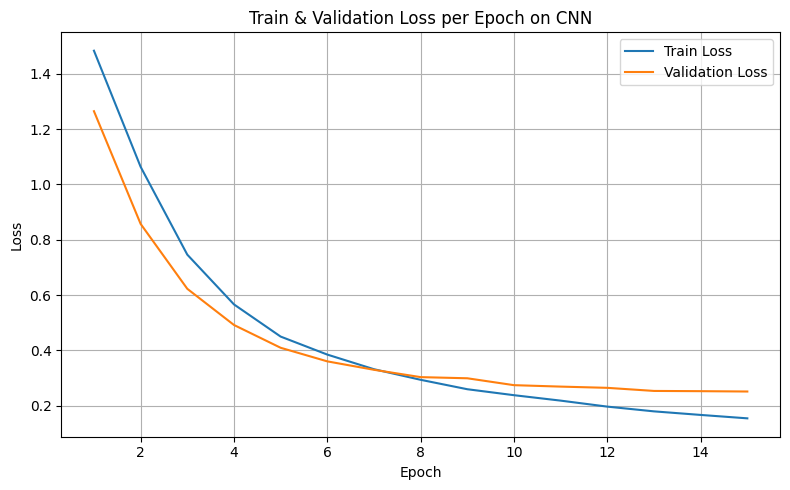

In [35]:
epochs = range(1, n_epochs + 1)

# Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(epochs, cnn_train_acc_list, label='Train Accuracy')
plt.plot(epochs, cnn_val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train & Validation Accuracy per Epoch on CNN')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Loss Curve
plt.figure(figsize=(8,5))
plt.plot(epochs, cnn_train_loss_list, label='Train Loss')
plt.plot(epochs, cnn_val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validation Loss per Epoch on CNN')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Save CNN Model

In [36]:
save_model = True
if save_model is True:
    torch.save(model_cnn,root_path+'Model Checkpoints/cnn_model_300d_epoch30.pkl')

Testset on CNN Model & Show Result

In [37]:
model_cnn.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_pred = model_cnn(x_batch)
        preds = F.softmax(y_pred, dim=1).argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y_batch.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

cnn_test_acc = accuracy_score(all_targets, all_preds) * 100
cnn_test_precision = precision_score(all_targets, all_preds, average='weighted') * 100
cnn_test_recall = recall_score(all_targets, all_preds, average='weighted') * 100
cnn_test_f1 = f1_score(all_targets, all_preds, average='weighted') * 100

cnn_mean_val_acc = np.mean(cnn_val_acc_list)
cnn_mean_val_precision = np.mean(cnn_prec_list)
cnn_mean_val_recall = np.mean(cnn_recall_list)
cnn_mean_val_f1 = np.mean(cnn_f1_list)

cnn_max_val_acc = max(cnn_val_acc_list)
cnn_max_val_precision = max(cnn_prec_list)
cnn_max_val_recall = max(cnn_recall_list)
cnn_max_val_f1 = max(cnn_f1_list)

print("*************************** Val ***************************")
print(f"Averag Val Accuracy: {cnn_mean_val_acc:.2f}%")
print(f"Averag Val Precision: {cnn_mean_val_precision:.2f}%")
print(f"Averag Val Recall: {cnn_mean_val_recall:.2f}%")
print(f"Averag Val F1 Score: {cnn_mean_val_f1:.2f}%")
print("*************************** Val Max ***************************")
print(f"Max Val Accuracy: {cnn_max_val_acc:.2f}%")
print(f"Max Val Precision: {cnn_max_val_precision:.2f}%")
print(f"Max Val Recall: {cnn_max_val_recall:.2f}%")
print(f"Max Val F1 Score: {cnn_max_val_f1:.2f}%")
print("*************************** Test ***************************")
print(f"Test Accuracy: {cnn_test_acc:.2f}%")
print(f"Test Precision: {cnn_test_precision:.2f}%")
print(f"Test Recall: {cnn_test_recall:.2f}%")
print(f"Test F1 Score: {cnn_test_f1:.2f}%")

*************************** Val ***************************
Averag Val Accuracy: 84.89%
Averag Val Precision: 88.64%
Averag Val Recall: 84.89%
Averag Val F1 Score: 86.26%
*************************** Val Max ***************************
Max Val Accuracy: 90.60%
Max Val Precision: 90.80%
Max Val Recall: 90.60%
Max Val F1 Score: 90.65%
*************************** Test ***************************
Test Accuracy: 89.30%
Test Precision: 89.32%
Test Recall: 89.30%
Test F1 Score: 89.26%


Bidirectional Long Short Term Memory (Bi-LSTM)

In [38]:
class BiLSTM(nn.Module):
    def __init__(self,n_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size,num_layers=1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(32, n_classes)


    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

Bi-LSTM Model Configure & Main Loop

In [39]:
model_bilstm = BiLSTM(n_classes).to(device)
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_bilstm.parameters()), lr=0.001)

# Load data in CUDA or CPU Memory
x_train = torch.tensor(train_sequences, dtype=torch.long).to(device)
y_train = torch.tensor(train_label, dtype=torch.long).to(device)
x_val = torch.tensor(val_sequences, dtype=torch.long).to(device)
y_val = torch.tensor(val_label, dtype=torch.long).to(device)
x_test = torch.tensor(test_sequences, dtype=torch.long).to(device)
y_test = torch.tensor(test_label, dtype=torch.long).to(device)

# Create Torch datasets
indices = np.arange(len(x_train))
train_set = torch.utils.data.TensorDataset(x_train, y_train, torch.tensor(indices))
val_set = torch.utils.data.TensorDataset(x_val, y_val)
test_set = torch.utils.data.TensorDataset(x_test, y_test)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

bilstm_train_loss_list = []
bilstm_val_loss_list = []
bilstm_train_acc_list, bilstm_val_acc_list, bilstm_prec_list, bilstm_recall_list, bilstm_f1_list = [],[],[],[],[]

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model_bilstm.train()
    avg_train_loss = 0.
    train_preds = np.zeros((len(x_train), n_classes))
    train_true = np.zeros(len(x_train))
    for i, (x_batch, y_batch, idx_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        # Predict/Forward Pass
        y_pred = model_bilstm(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        preds = F.softmax(y_pred, dim=1).detach().cpu().numpy()
        idxs = idx_batch.cpu().numpy()
        train_preds[idxs] = preds
        train_true[idxs] = y_batch.cpu().numpy()

        avg_train_loss += loss.item() / len(train_loader)


    y_pred_train = train_preds.argmax(axis=1)
    train_accuracy = round(accuracy_score(y_pred_train, train_true)*100,3)

    # Set model to validation configuration -Doesn't get trained here
    model_bilstm.eval()
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_val), n_classes))
    with torch.no_grad():
      for i, (x_batch, y_batch) in enumerate(val_loader):
          y_pred = model_bilstm(x_batch)
          start_idx = i * batch_size
          end_idx = start_idx + len(x_batch)
          loss = loss_fn(y_pred, y_batch)
          # keep/store predictions
          val_preds[start_idx:end_idx] = F.softmax(y_pred, dim=1).detach().cpu().numpy()
          avg_val_loss += loss.item() / len(val_loader)
    # Check Accuracy
    y_pred_val = val_preds.argmax(axis=1)
    val_accuracy = round(accuracy_score(y_pred_val, y_val.cpu().numpy())*100,3)
    val_precision = round(precision_score(y_pred_val, y_val.cpu().numpy(), average='weighted')*100,3)
    val_recall = round(recall_score(y_pred_val, y_val.cpu().numpy(), average='weighted')*100,3)
    val_f1_score = round(f1_score(y_pred_val, y_val.cpu().numpy(), average='weighted')*100,3)


    # storing accuracy,precision,recall,f1 score data into list
    bilstm_train_loss_list.append(avg_train_loss)
    bilstm_val_loss_list.append(avg_val_loss)
    bilstm_train_acc_list.append(train_accuracy)
    bilstm_val_acc_list.append(val_accuracy)
    bilstm_prec_list.append(val_precision)
    bilstm_recall_list.append(val_recall)
    bilstm_f1_list.append(val_f1_score)
    elapsed_time = time.time() - start_time
    print("Epoch {}/{}  Train loss={:.3f}   Val loss={:.3f}   Train Accuracy={:.3f}   Val Accuracy={:.3f}   Precision={:.3f}   Recall={:.3f}   F1 Score={:.3f}   time={:.2f} s".format(
                epoch + 1, n_epochs, avg_train_loss, avg_val_loss, train_accuracy, val_accuracy, val_precision, val_recall, val_f1_score, elapsed_time))

Epoch 1/15  Train loss=1.626   Val loss=1.574   Train Accuracy=32.681   Val Accuracy=35.200   Precision=100.000   Recall=35.200   F1 Score=52.071   time=47.71 s
Epoch 2/15  Train loss=1.543   Val loss=1.460   Train Accuracy=38.312   Val Accuracy=44.350   Precision=83.573   Recall=44.350   F1 Score=56.173   time=46.13 s
Epoch 3/15  Train loss=1.329   Val loss=1.167   Train Accuracy=51.231   Val Accuracy=56.000   Precision=89.269   Recall=56.000   F1 Score=68.001   time=46.14 s
Epoch 4/15  Train loss=1.119   Val loss=0.997   Train Accuracy=56.100   Val Accuracy=58.350   Precision=92.867   Recall=58.350   F1 Score=70.943   time=47.35 s
Epoch 5/15  Train loss=0.939   Val loss=0.808   Train Accuracy=64.075   Val Accuracy=70.750   Precision=88.445   Recall=70.750   F1 Score=77.164   time=46.39 s
Epoch 6/15  Train loss=0.733   Val loss=0.602   Train Accuracy=74.500   Val Accuracy=78.500   Precision=88.780   Recall=78.500   F1 Score=82.594   time=47.16 s
Epoch 7/15  Train loss=0.560   Val loss

Bi-LSTM Model Evaluation

In [41]:
bilstm_mean_train_acc = np.mean(bilstm_train_acc_list)
bilstm_mean_val_acc = np.mean(bilstm_val_acc_list)
bilstm_mean_train_loss = np.mean(bilstm_train_loss_list)
bilstm_mean_val_loss = np.mean(bilstm_val_loss_list)

print(f"Averag Train Accuracy on Bi-LSTM: {bilstm_mean_train_acc:.3f}")
print(f"Averag Val Accuracy on Bi-LSTM: {bilstm_mean_val_acc:.3f}")
print(f"Averag Train Loss on Bi-LSTM: {bilstm_mean_train_loss:.3f}")
print(f"Averag Val Loss on Bi-LSTM: {bilstm_mean_val_loss:.3f}")

Averag Train Accuracy on Bi-LSTM: 74.719
Averag Val Accuracy on Bi-LSTM: 76.247
Averag Train Loss on Bi-LSTM: 0.669
Averag Val Loss on Bi-LSTM: 0.613


Bi-LSTM Model Visualisation

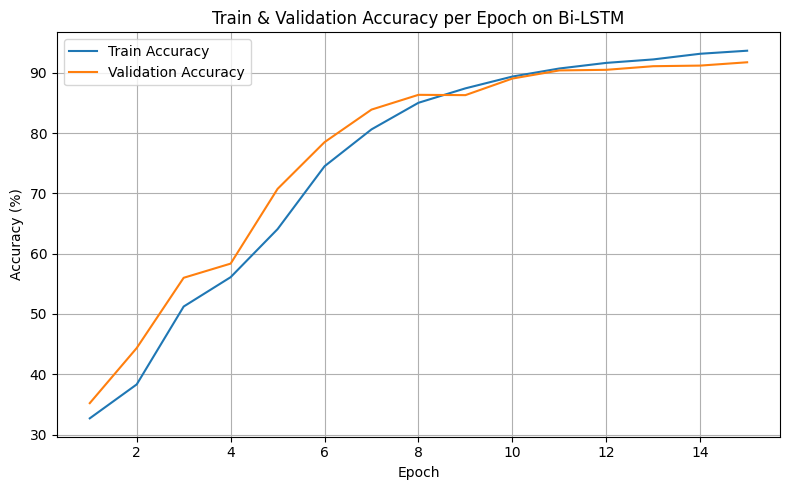

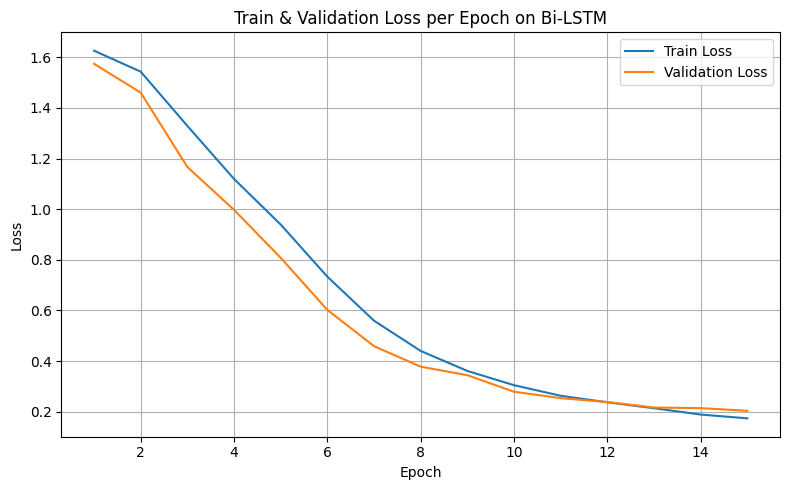

In [42]:
epochs = range(1, n_epochs + 1)

# Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(epochs, bilstm_train_acc_list, label='Train Accuracy')
plt.plot(epochs, bilstm_val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train & Validation Accuracy per Epoch on Bi-LSTM')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Loss Curve
plt.figure(figsize=(8,5))
plt.plot(epochs, bilstm_train_loss_list, label='Train Loss')
plt.plot(epochs, bilstm_val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validation Loss per Epoch on Bi-LSTM')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Save Bi-LSTM Model

In [43]:
save_model = True
if save_model is True:
    torch.save(model_bilstm,root_path+'Model Checkpoints/final_bilstm_model_300d_layer1_epoch30.pkl')

Testset on Bi-LSTM Model & Show Result

In [44]:
model_bilstm.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_pred = model_bilstm(x_batch)
        preds = F.softmax(y_pred, dim=1).argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y_batch.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

bilstm_test_acc = accuracy_score(all_targets, all_preds) * 100
bilstm_test_precision = precision_score(all_targets, all_preds, average='weighted') * 100
bilstm_test_recall = recall_score(all_targets, all_preds, average='weighted') * 100
bilstm_test_f1 = f1_score(all_targets, all_preds, average='weighted') * 100

bilstm_mean_val_acc = np.mean(bilstm_val_acc_list)
bilstm_mean_val_precision = np.mean(bilstm_prec_list)
bilstm_mean_val_recall = np.mean(bilstm_recall_list)
bilstm_mean_val_f1 = np.mean(bilstm_f1_list)

bilstm_max_val_acc = max(bilstm_val_acc_list)
bilstm_max_val_precision = max(bilstm_prec_list)
bilstm_max_val_recall = max(bilstm_recall_list)
bilstm_max_val_f1 = max(bilstm_f1_list)

print("*************************** Val ***************************")
print(f"Averag Val Accuracy: {bilstm_mean_val_acc:.2f}%")
print(f"Averag Val Precision: {bilstm_mean_val_precision:.2f}%")
print(f"Averag Val Recall: {bilstm_mean_val_recall:.2f}%")
print(f"Averag Val F1 Score: {bilstm_mean_val_f1:.2f}%")
print("*************************** Val Max ***************************")
print(f"Averag Val Accuracy: {bilstm_max_val_acc:.2f}%")
print(f"Averag Val Precision: {bilstm_max_val_precision:.2f}%")
print(f"Averag Val Recall: {bilstm_max_val_recall:.2f}%")
print(f"Averag Val F1 Score: {bilstm_max_val_f1:.2f}%")
print("*************************** Test ***************************")
print(f"Test Accuracy: {bilstm_test_acc:.2f}%")
print(f"Test Precision: {bilstm_test_precision:.2f}%")
print(f"Test Recall: {bilstm_test_recall:.2f}%")
print(f"Test F1 Score: {bilstm_test_f1:.2f}%")

*************************** Val ***************************
Averag Val Accuracy: 76.25%
Averag Val Precision: 90.32%
Averag Val Recall: 76.25%
Averag Val F1 Score: 80.75%
*************************** Val Max ***************************
Averag Val Accuracy: 91.75%
Averag Val Precision: 100.00%
Averag Val Recall: 91.75%
Averag Val F1 Score: 91.77%
*************************** Test ***************************
Test Accuracy: 90.95%
Test Precision: 90.91%
Test Recall: 90.95%
Test F1 Score: 90.91%


Comparison

<Figure size 1200x1000 with 0 Axes>

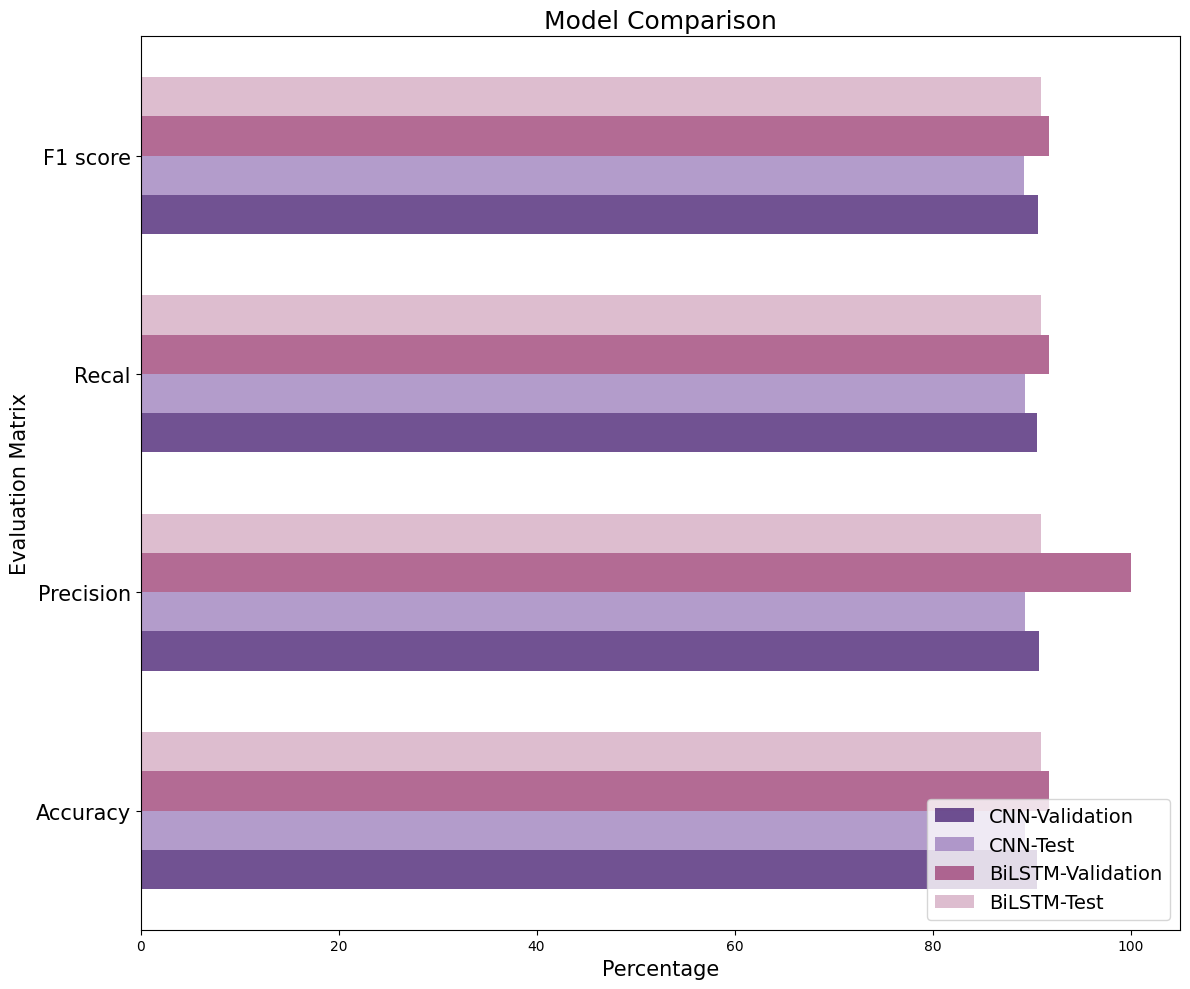

In [46]:
fig = plt.figure(figsize = (12, 10))
w =0.3
x_axis = ["Accuracy","Precision","Recal","F1 score"]
cnn_val = []
cnn_val.append(max(cnn_val_acc_list))
cnn_val.append(max(cnn_prec_list))
cnn_val.append(max(cnn_recall_list))
cnn_val.append(max(cnn_f1_list))
cnn_test = []
cnn_test.append(cnn_test_acc)
cnn_test.append(cnn_test_precision)
cnn_test.append(cnn_test_recall)
cnn_test.append(cnn_test_f1)
bilstm_val = []
bilstm_val.append(max(bilstm_val_acc_list))
bilstm_val.append(max(bilstm_prec_list))
bilstm_val.append(max(bilstm_recall_list))
bilstm_val.append(max(bilstm_f1_list))
bilstm_test = []
bilstm_test.append(bilstm_test_acc)
bilstm_test.append(bilstm_test_precision)
bilstm_test.append(bilstm_test_recall)
bilstm_test.append(bilstm_test_f1)

all_methods = ['CNN-Validation', 'CNN-Test', 'BiLSTM-Validation', 'BiLSTM-Test']
all_data = [cnn_val, cnn_test, bilstm_val, bilstm_test]
n_metrics = len(x_axis)
n_methods = len(all_methods)

y = np.arange(n_metrics)
bar_height = 0.18

plt.figure(figsize=(12,10))

for i, (data, label, color) in enumerate(zip(
    all_data,
    all_methods,
    ['#4d2777', '#a083bf', '#a0467a', '#d5adc4']
)):
    plt.barh(y + (i-1.5)*bar_height, data, height=bar_height, label=label, color=color, alpha=0.8)

plt.yticks(y, x_axis, fontsize=15)
plt.xlabel('Percentage', fontsize=15)
plt.ylabel('Evaluation Matrix', fontsize=15)
plt.title('Model Comparison', fontsize=18)
plt.legend(fontsize=14, loc='lower right')
plt.xlim(0, 105)
plt.tight_layout()
plt.show()